# Towards a Solution for Improving Customer Data Quality at Triodos Bank
### by Lade Tawak


## Dataset selection

When I started this exploration, I found [this dataset on GitHub](https://github.com/jorritb/dutch-postal-codes/blob/master/postcodes_20190613.csv) which contains over 76000 Dutch addresses and their corresponding postcodes, although it is from 2019.

I later found another [dataset from the Dutch Central Bureau  of Statistics (CBS)](https://www.cbs.nl/nl-nl/maatwerk/2023/35/buurt-wijk-en-gemeente-2023-voor-postcode-huisnummer) which contains all the postcodes and their corresponding cities. It is from 2023 and is the most recent one on their website. This was used for Phase 2 and 3.

# Phase 1
# A. First exploration with the GitHub dataset of 76k addresses

## A1. Preprocessing

To get started, I imported the necessary libraries and loaded the dataset into a Pandas DataFrame. I used ``head()``, ``info()``, ``describe()``, ``isnull().sum()`` to explore the data, understand its structure and content, determine what to do with missing values, and decide what type of cleaning is needed if any

In [ ]:
%pip install seaborn
%pip install scikit-learn
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
addresses = pd.read_csv('addresses_NL.csv')
addresses.head()

,postal_code,street,house_numbers,city,area,neighborhood,municipality,province
0,9573PA,1e Exloërmond,3 t/m 22,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe
1,9573PB,1e Exloërmond,23 t/m 43,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe
2,9573PC,1e Exloërmond,46 t/m 59,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe
3,9573PD,1e Exloërmond,60 t/m 83,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe
4,9573PE,1e Exloërmond,84 t/m 101,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe


In [ ]:
addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76503 entries, 0 to 76502
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   postal_code    76503 non-null  object
 1   street         76503 non-null  object
 2   house_numbers  76503 non-null  object
 3   city           76503 non-null  object
 4   area           76503 non-null  object
 5   neighborhood   76503 non-null  object
 6   municipality   76076 non-null  object
 7   province       76503 non-null  object
dtypes: object(8)
memory usage: 4.7+ MB


The dataset contains addresses 76,502 addresses in the Netherlands broken into 8 columns:
- postal_code: The 6 digit postal code containing 4 numbers and 2 letters.
- street: The street name
- house_number: The house numbers that match the postal code and street
- city: The name of the city
- area: The name of the area where the area is located
- neighborhood: The name of the neighborhood where the area is located
- municipality: The name of the municipality where the neighborhood is located
- province: The name of the province where the municipality is located

They are all strings values

In [ ]:
null_counts = addresses.isnull().sum()
null_counts

postal_code        0
street             0
house_numbers      0
city               0
area               0
neighborhood       0
municipality     427
province           0
dtype: int64

The municipality column has some missing values, however it is not a significant amount (less than 1% of the total values in the column). I want to further explore the missing values in the municipality column to determine if there is any pattern or reason

In [ ]:
addresses[addresses['municipality'].isnull()]

,postal_code,street,house_numbers,city,area,neighborhood,municipality,province
3453,8841KE,Alde Bayumerdyk,1 t/m 10,Baaium,Wijk 01 Noord,Baaium,NaN,Friesland
3454,8841KG,Hasthemerwei,1 t/m 12,Baaium,Wijk 01 Noord,Baaium,NaN,Friesland
3455,8841KH,Buorren,1 t/m 21,Baaium,Wijk 01 Noord,Baaium,NaN,Friesland
3456,8841KH,Foarstreek,2 t/m 10,Baaium,Wijk 01 Noord,Baaium,NaN,Friesland
3457,8841KJ,Alde Dyk,1 t/m 11,Baaium,Wijk 01 Noord,Baaium,NaN,Friesland
...,...,...,...,...,...,...,...,...
73279,8731BT,Hofkamp,33 t/m 59,Wommels,Wijk 00 Zuid,Wommels,NaN,Friesland
73280,8731BV,Hofkamp,2 t/m 32,Wommels,Wijk 00 Zuid,Wommels,NaN,Friesland
73281,8731BW,Hofkamp,36 t/m 72,Wommels,Wijk 00 Zuid,Wommels,NaN,Friesland
73282,8731BX,Stroek,1 t/m 9,Wommels,Wijk 00 Zuid,Wommels,NaN,Friesland


It appears that all the missing municipalities are in the Friesland province. Based on the fact that the missing municipalities are all in the same province, it is likely that the missing data is due to a data entry error.

To validate that all the missing municipalities are in Friesland, I will check the number of rows that have missing values for the municipality column in Friesland

In [ ]:
friesland_data = addresses[addresses['province'] == 'Friesland']
friesland_data.isnull().sum()

postal_code        0
street             0
house_numbers      0
city               0
area               0
neighborhood       0
municipality     427
province           0
dtype: int64

There are 427 missing municipalities in the friesland_data dataframe, which is the exact same number of missing municipalities in the addresses dataframe, so I can conclude that all the missing municipalities are in Friesland.

I don't perceive this will be a problem for the analysis, so I won't drop the rows. I will also not fill in the missing values because I don't have enough time to gather all the data needed to do so accurately and I wouldn't want to use an estimation (like filling with the `mode`) because it could impact the model later

In [ ]:
addresses.describe(include='all')

,postal_code,street,house_numbers,city,area,neighborhood,municipality,province
count,76503,76503,76503,76503,76503,76503,76076,76503
unique,74573,31025,7544,2473,1809,5066,380,12
top,7051AK,Dorpsstraat,1 t/m 1,Buren,Wijk 00,Centrum,Súdwest-Fryslân,Gelderland
freq,3,962,1209,82,2497,447,1256,12793


From the `.describe()` method above, I see that there are 74,573 postal codes in the dataset which is almost the same as the total number of rows. This would be unreasonable for building the model to match cities to postal codes.

Also, in the Dutch postal code system, the first digit usually represents the province and all 4 digits often represent the city or even a specific neighbourhood. The 2 letters narrow it down to a street name or part of the street. Based on this, I have decided to split the postal code into just the first digits and ignore the letters in building a model. I have also created a new column called `postcode_digits` which contains just the first 4 digits of the postal code.

I will also drop the `'postal_code'` and `'house_numbers'` columns as they are not relevant for the model because house numbers are not unique and postal codes are already represented by the `postcode_digits` column.

In [ ]:
addresses['postcode_digits'] = addresses['postal_code'].str[:4]

The `postcode_digits` is stored as a string because although it is a number, it is not a number in the sense of a mathematical number. It is a string of characters which map to postcodes

In [ ]:
addresses_clean = addresses.drop(columns=['house_numbers', 'postal_code'])
addresses_clean

,street,city,area,neighborhood,municipality,province,postcode_digits
0,1e Exloërmond,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe,9573
1,1e Exloërmond,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe,9573
2,1e Exloërmond,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe,9573
3,1e Exloërmond,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe,9573
4,1e Exloërmond,1e Exloërmond,Wijk 15 Tweede Exloërmond,Eerste Exloërmond,Borger-Odoorn,Drenthe,9573
...,...,...,...,...,...,...,...
76498,Westerlaan,Zwolle,Wijk 13 Assendorp,Stationsbuurt,Zwolle,Overijssel,8011
76499,Westerlaan,Zwolle,Wijk 13 Assendorp,Stationsbuurt,Zwolle,Overijssel,8011
76500,Westerlaan,Zwolle,Wijk 13 Assendorp,Stationsbuurt,Zwolle,Overijssel,8011
76501,Westerstraat,Zwolle,Wijk 13 Assendorp,Stationsbuurt,Zwolle,Overijssel,8011


I did not calculate outliers because it is all categorical data.

Now, I will calculate the correlation between the variables. Because these are categorical variables, I will use the chi-square test.

In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

categorical_columns = ['street', 'city', 'area', 'neighborhood', 'municipality', 'province']

# Create an empty correlation matrix
corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Fill the matrix with Cramer's V values
for col1 in categorical_columns:
    for col2 in categorical_columns:
        corr_matrix.loc[col1, col2] = cramers_v(addresses_clean[col1], addresses_clean[col2])

# Display the correlation matrix
print(corr_matrix)

                street      city      area neighborhood municipality  province
street             1.0  0.495119   0.47723     0.445345     0.510418  0.556375
city          0.495119       1.0  0.922178     0.940394     0.981656  0.979717
area           0.47723  0.922178       1.0     0.948817     0.911363  0.953944
neighborhood  0.445345  0.940394  0.948817          1.0     0.939316   0.95395
municipality  0.510418  0.981656  0.911363     0.939316          1.0  0.993914
province      0.556375  0.979717  0.953944      0.95395     0.993914       1.0


`street` doesn't correlate highly with any other feature, although it is just over the half point with `municipality` and `province`. All the other features are strongly correlated with each other.

I will drop the following features:
- `province`: because it is almost perfectly correlated with `municipality`
- `area`: because it has a high correlation with `neighborhood`

In [ ]:
selected_addresses = addresses_clean.drop(columns=['area', 'province'])

## A2. Building the models

Because this is a classification problem (it is a categorical variable we are trying to predict), I will explore the following models:
- k-NN
- Decision Tree
- Neural Network with Keras

### A2.1 k-NN Classification

Now that I have selected the features for my model, I need have to create dummies for the selected features and then create my X and y variables.

In [ ]:
selected_addresses = pd.get_dummies(selected_addresses, columns=['street', 'neighborhood', 'municipality', 'postcode_digits'], drop_first=True)
selected_addresses

,city,street_'s Gravenhoven,street_'s Gravenlust,street_'s Heer Boeijenstraat,street_'s-Gravelandseweg,street_'s-Gravenhof,street_'s-Gravenhofplein,street_'s-Gravenhofstraat,street_'s-Gravenpoldersestraat,street_'s-Gravensloot,...,postcode_digits_9989,postcode_digits_9991,postcode_digits_9992,postcode_digits_9993,postcode_digits_9994,postcode_digits_9995,postcode_digits_9996,postcode_digits_9997,postcode_digits_9998,postcode_digits_9999
0,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76498,Zwolle,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76499,Zwolle,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76500,Zwolle,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76501,Zwolle,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X=selected_addresses.drop(columns=['city'])
y=selected_addresses['city']

Next, I am splitting the data into a training set and test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)
pd.DataFrame(X_train).head()

,street_'s Gravenhoven,street_'s Gravenlust,street_'s Heer Boeijenstraat,street_'s-Gravelandseweg,street_'s-Gravenhof,street_'s-Gravenhofplein,street_'s-Gravenhofstraat,street_'s-Gravenpoldersestraat,street_'s-Gravensloot,street_'s-Gravenstraat,...,postcode_digits_9989,postcode_digits_9991,postcode_digits_9992,postcode_digits_9993,postcode_digits_9994,postcode_digits_9995,postcode_digits_9996,postcode_digits_9997,postcode_digits_9998,postcode_digits_9999
22017,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
75444,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1071,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1980,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16713,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5) #create a KNN-classifier with 5 neighbors (default)
knn = knn.fit(X_train, y_train) #train the model

#### A2.1.1 Model Evaluation: k-NN

**Evaluating accuracy**
First, I calculcate the accuracy of the model on the test data.

In [ ]:
knn.score(X_test, y_test)

0.9938564768419677

The model has very high accuracy, almost 100%

**evaluating precision and recall**

because, there are so many possible classes, I'll jusmp straight to using a classification report

In [ ]:
y_test_pred = knn.predict(X_test)
print(classification_report(y_test, y_test_pred))

                                    precision    recall  f1-score   support

                     's Gravenmoer       1.00      1.00      1.00         8
                      's-Graveland       1.00      0.92      0.96        12
                     's-Gravendeel       1.00      1.00      1.00        11
                   's-Gravenpolder       1.00      1.00      1.00        12
                    's-Gravenzande       1.00      1.00      1.00        14
                 's-Heer Abtskerke       1.00      1.00      1.00        10
               's-Heer Arendskerke       1.00      1.00      1.00         7
          's-Heer Hendrikskinderen       1.00      1.00      1.00        12
                     's-Heerenberg       1.00      1.00      1.00        10
                    's-Heerenbroek       1.00      1.00      1.00         5
                     's-Heerenhoek       1.00      1.00      1.00        16
                            't Goy       1.00      1.00      1.00         6
           

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

#### A2.1.2 Parameter setting for k-NN

In [ ]:
from sklearn.metrics import classification_report

for i in range(1,11):
    knn_new = KNeighborsClassifier(n_neighbors = i)
    knn_new = knn_new.fit(X_train, y_train)
    y_test_pred_new = knn_new.predict(X_test)
    print(f"With {i} neighbors the result is:")
    print(classification_report(y_test, y_test_pred_new))


#### A2.1.3 Discussion of k-NN Results

In my first iteration of the model, I dropped "Street" because it did not correlate highly with any of the other variables column. I also don't think that street is a useful variable for the model because there were too many unique values.

| 5 neighbors                      | **precision**              | **recall**                  | **f1-score** | **support** |
|--------------------------|---------------------------|-----------------------------|--------------|-------------|
| **accuracy**             |         |         | 0.99 | 22951 |
| **macro avg**            | 0.96 | 0.97 | 0.96 | 22951 |
| **weighted avg**          | 0.99 | 0.99 | 0.99 | 22951 |
*The actual accuracy score of the model without "street": 0.9903707899437934*

But when I ran the model again with "Street" as a feature(as seen in this notebook), the results were marginally better
| **5 neighbors** | **precision**| **recall**| **f1-score** | **support** |
|--------------------------|---------------------------|-----------------------------|--------------|-------------|
|accuracy                   |           |           |     0.99  |   22951|
|macro avg                  | 0.97    |  0.98  |    0.97  |   22951|
|weighted avg              | 0.99  |    0.99   |   0.99  |   22951 |
*The actual accuracy score of the model with "street": 0.9938564768419677*


Furthermore, I drilled in on some cities. In the first model where I dropped "Street" the results were as follows:
| cities                      | **precision**              | **recall**                  | **f1-score** | **support** |
|--------------------------|---------------------------|-----------------------------|--------------|-------------|
|'t Veld           |  0.87   |   1.00   |   0.93    |    13 |
|'t Waar           |  1.00   |   1.00   |   1.00    |     2 |
|'t Zand           |  1.00   |   1.00   |   1.00    |    14 |
|'t Zandt          |  1.00   |   1.00   |   1.00    |    10 |
|1e Exloërmond     |  1.00   |   1.00   |   1.00    |     1 |
|2e Exloërmond     |  0.90   |   1.00   |   0.95    |     9 |
|2e Valthermond    |  0.00   |   0.00   |   0.00    |     2 |


while in the new model where I kept "Street" (what you can see in this notebook) the results were as follows:
| cities                      | **precision**              | **recall**                  | **f1-score** | **support** |
|--------------------------|---------------------------|-----------------------------|--------------|-------------|
| 't Veld          |   0.87   |   1.00    |  0.93      |  13 |
| 't Waar          |   0.00   |   0.00    |  0.00      |   2 |
| 't Zand          |   0.93   |   1.00    |  0.97      |  14 |
|'t Zandt          |  0.83    |  1.00     | 0.91       | 10 |
| 1e Exloërmond    |   1.00   |   1.00    |  1.00      |   1 |
| 2e Exloërmond    |   0.69   |   1.00    |  0.82      |   9 |

For the most part, the model with `Street` in it has better f1 scores. So, I conclude that the model is slightly more effective when `Street` is included as a feature. `Postcode_digit` is also an essential feature as it is one of the key markers in the Dutch postal system.

It is possible that a model using only these 2 features (`Street` and `Postcode_digit`) would be as effective as the model containing the 4 features used. Or including one more (given the high correlation between ``neighbourhoood`` and ``municipality``). Reducing the number of features as such could improve simplicity and computational efficiency.

Finally, although, setting the number of neighbors to 1 has the highest accuracy and f1 scores, there is a risk of overfitting. Because of this, I would go with using 5 or 6 neighbors as the accuracy and f1 scores are still very high, and the model is less likely to overfit.

### A2.2 Decision Tree Model

The target variable is the "city" column.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(addresses_clean['city'])

There are no numerical variables, so I will not be using the correlation matrix.

In [ ]:
addresses_encoded = addresses_clean.drop(columns=['area', 'province'])
# Encode categorical variables (the variable that have not been encoded)
categorical_columns = ['street', 'neighborhood', 'municipality', 'postcode_digits']
for col in categorical_columns:
    label_encoder = LabelEncoder()
    addresses_encoded.loc[:, col] = label_encoder.fit_transform(addresses_encoded[col])

addresses_encoded.head()

,street,city,neighborhood,municipality,postcode_digits
0,236,1e Exloërmond,1123,46,2356
1,236,1e Exloërmond,1123,46,2356
2,236,1e Exloërmond,1123,46,2356
3,236,1e Exloërmond,1123,46,2356
4,236,1e Exloërmond,1123,46,2356


splitting the data into training and test data

In [ ]:
# Define features (X) and target (y)
X = addresses_encoded.drop(columns=['city']) #everything except the target variable
y = addresses_encoded['city']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### A2.2.1 Model evaluation - Decision Tree Classifier

In [ ]:
from sklearn.tree import plot_tree

dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=3)
dt_classifier.fit(X_train, y_train)

#predict and evaluate the model
y_pred_tree = dt_classifier.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.0030064049496753955
                                  precision    recall  f1-score   support

                   's Gravenmoer       0.00      0.00      0.00        15
                    's-Graveland       0.24      1.00      0.39        10
                   's-Gravendeel       0.00      0.00      0.00        16
                 's-Gravenpolder       1.00      1.00      1.00         7
                  's-Gravenzande       0.00      0.00      0.00         9
               's-Heer Abtskerke       0.00      0.00      0.00        10
             's-Heer Arendskerke       0.00      0.00      0.00        12
        's-Heer Hendrikskinderen       0.00      0.00      0.00         7
                   's-Heerenberg       0.00      0.00      0.00        12
                  's-Heerenbroek       0.00      0.00      0.00         1
                   's-Heerenhoek       0.00      0.00      0.00        16
                          't Goy       0.00      0.00      0.00  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Now I'm visualising the tree

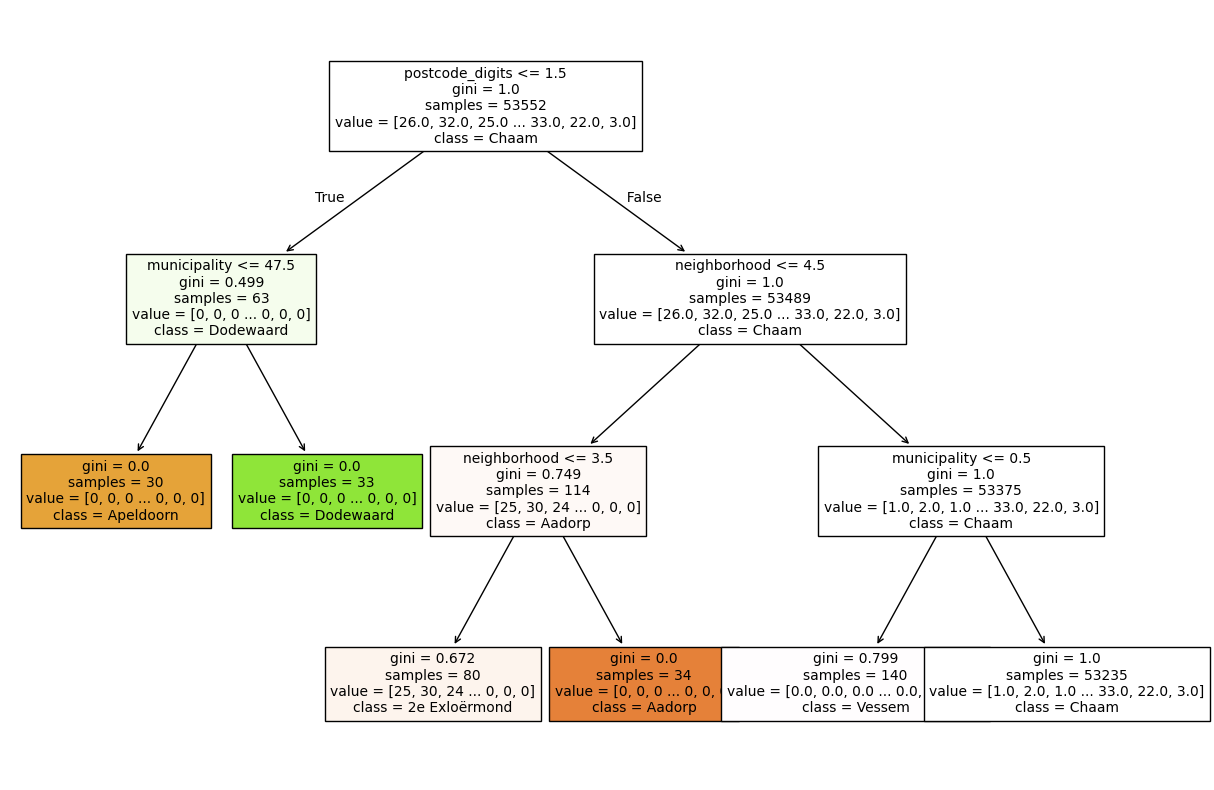

In [ ]:
# Visualize the tree
plt.figure(figsize=(15, 10))


class_names = addresses_encoded['city'].unique().tolist()

plot_tree(dt_classifier, feature_names=X.columns, class_names=class_names, filled=True, fontsize=10)
plt.show()

Reading the graph:

* **Left branch**: Represents duration <= 1.5 (True).
* **Right branch**: Represents duration > 1.5 (False).
* **Node color**: Indicates the predicted class (No = orange, Yes = blue).
* **Color intensity**: Reflects the purity or confidence of the prediction (darker = more confident, with a lower Gini index; lighter = less confident, with a higher Gini index).

**Conclusion**
Some nodes have a Gini of 0, indicating perfect purity where all samples belong to the same class. Others have higher Gini values, suggesting more mixed classifications.

In the current analysis, ``postcode_digits`` is the most important feature used in this prediction model. Based on this insight, refining the model by removing less important features like `street`, which does not seem to have been taken into account at all could improve simplicity and computational efficiency without compromising accuracy.

#### A2.2.2 GridSearchCV for hyperparameter testing
To optimize model performance, we can use GridSearchCV to find the best hyperparameters for our Decision Tree model.

In [ ]:
# Decision Tree Hyperparameter Tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search_tree.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters for Decision Tree:", grid_search_tree.best_params_)
print("Best Cross-Validated Accuracy:", grid_search_tree.best_score_)

# Evaluate on the test set
best_tree = grid_search_tree.best_estimator_
y_pred_best_tree = best_tree.predict(X_test)
print("Test Accuracy of Tuned Decision Tree:", accuracy_score(y_test, y_pred_best_tree))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validated Accuracy: 0.991167473506311
Test Accuracy of Tuned Decision Tree: 0.9918086357892902


I ran the model again, using the recommended parameters from the grid search

In [ ]:
best_dt_classifier = DecisionTreeClassifier(random_state=42,
                                          max_depth=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2)

best_dt_classifier.fit(X_train, y_train)

best_y_pred_tree = best_dt_classifier.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, best_y_pred_tree))
print(classification_report(y_test, best_y_pred_tree))

Decision Tree Accuracy: 0.9918086357892902
                                  precision    recall  f1-score   support

                   's Gravenmoer       1.00      0.93      0.97        15
                    's-Graveland       1.00      1.00      1.00        10
                   's-Gravendeel       1.00      1.00      1.00        16
                 's-Gravenpolder       1.00      1.00      1.00         7
                  's-Gravenzande       1.00      1.00      1.00         9
               's-Heer Abtskerke       1.00      1.00      1.00        10
             's-Heer Arendskerke       1.00      1.00      1.00        12
        's-Heer Hendrikskinderen       1.00      1.00      1.00         7
                   's-Heerenberg       1.00      1.00      1.00        12
                  's-Heerenbroek       1.00      1.00      1.00         1
                   's-Heerenhoek       1.00      1.00      1.00        16
                          't Goy       1.00      1.00      1.00     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

and then visualised it

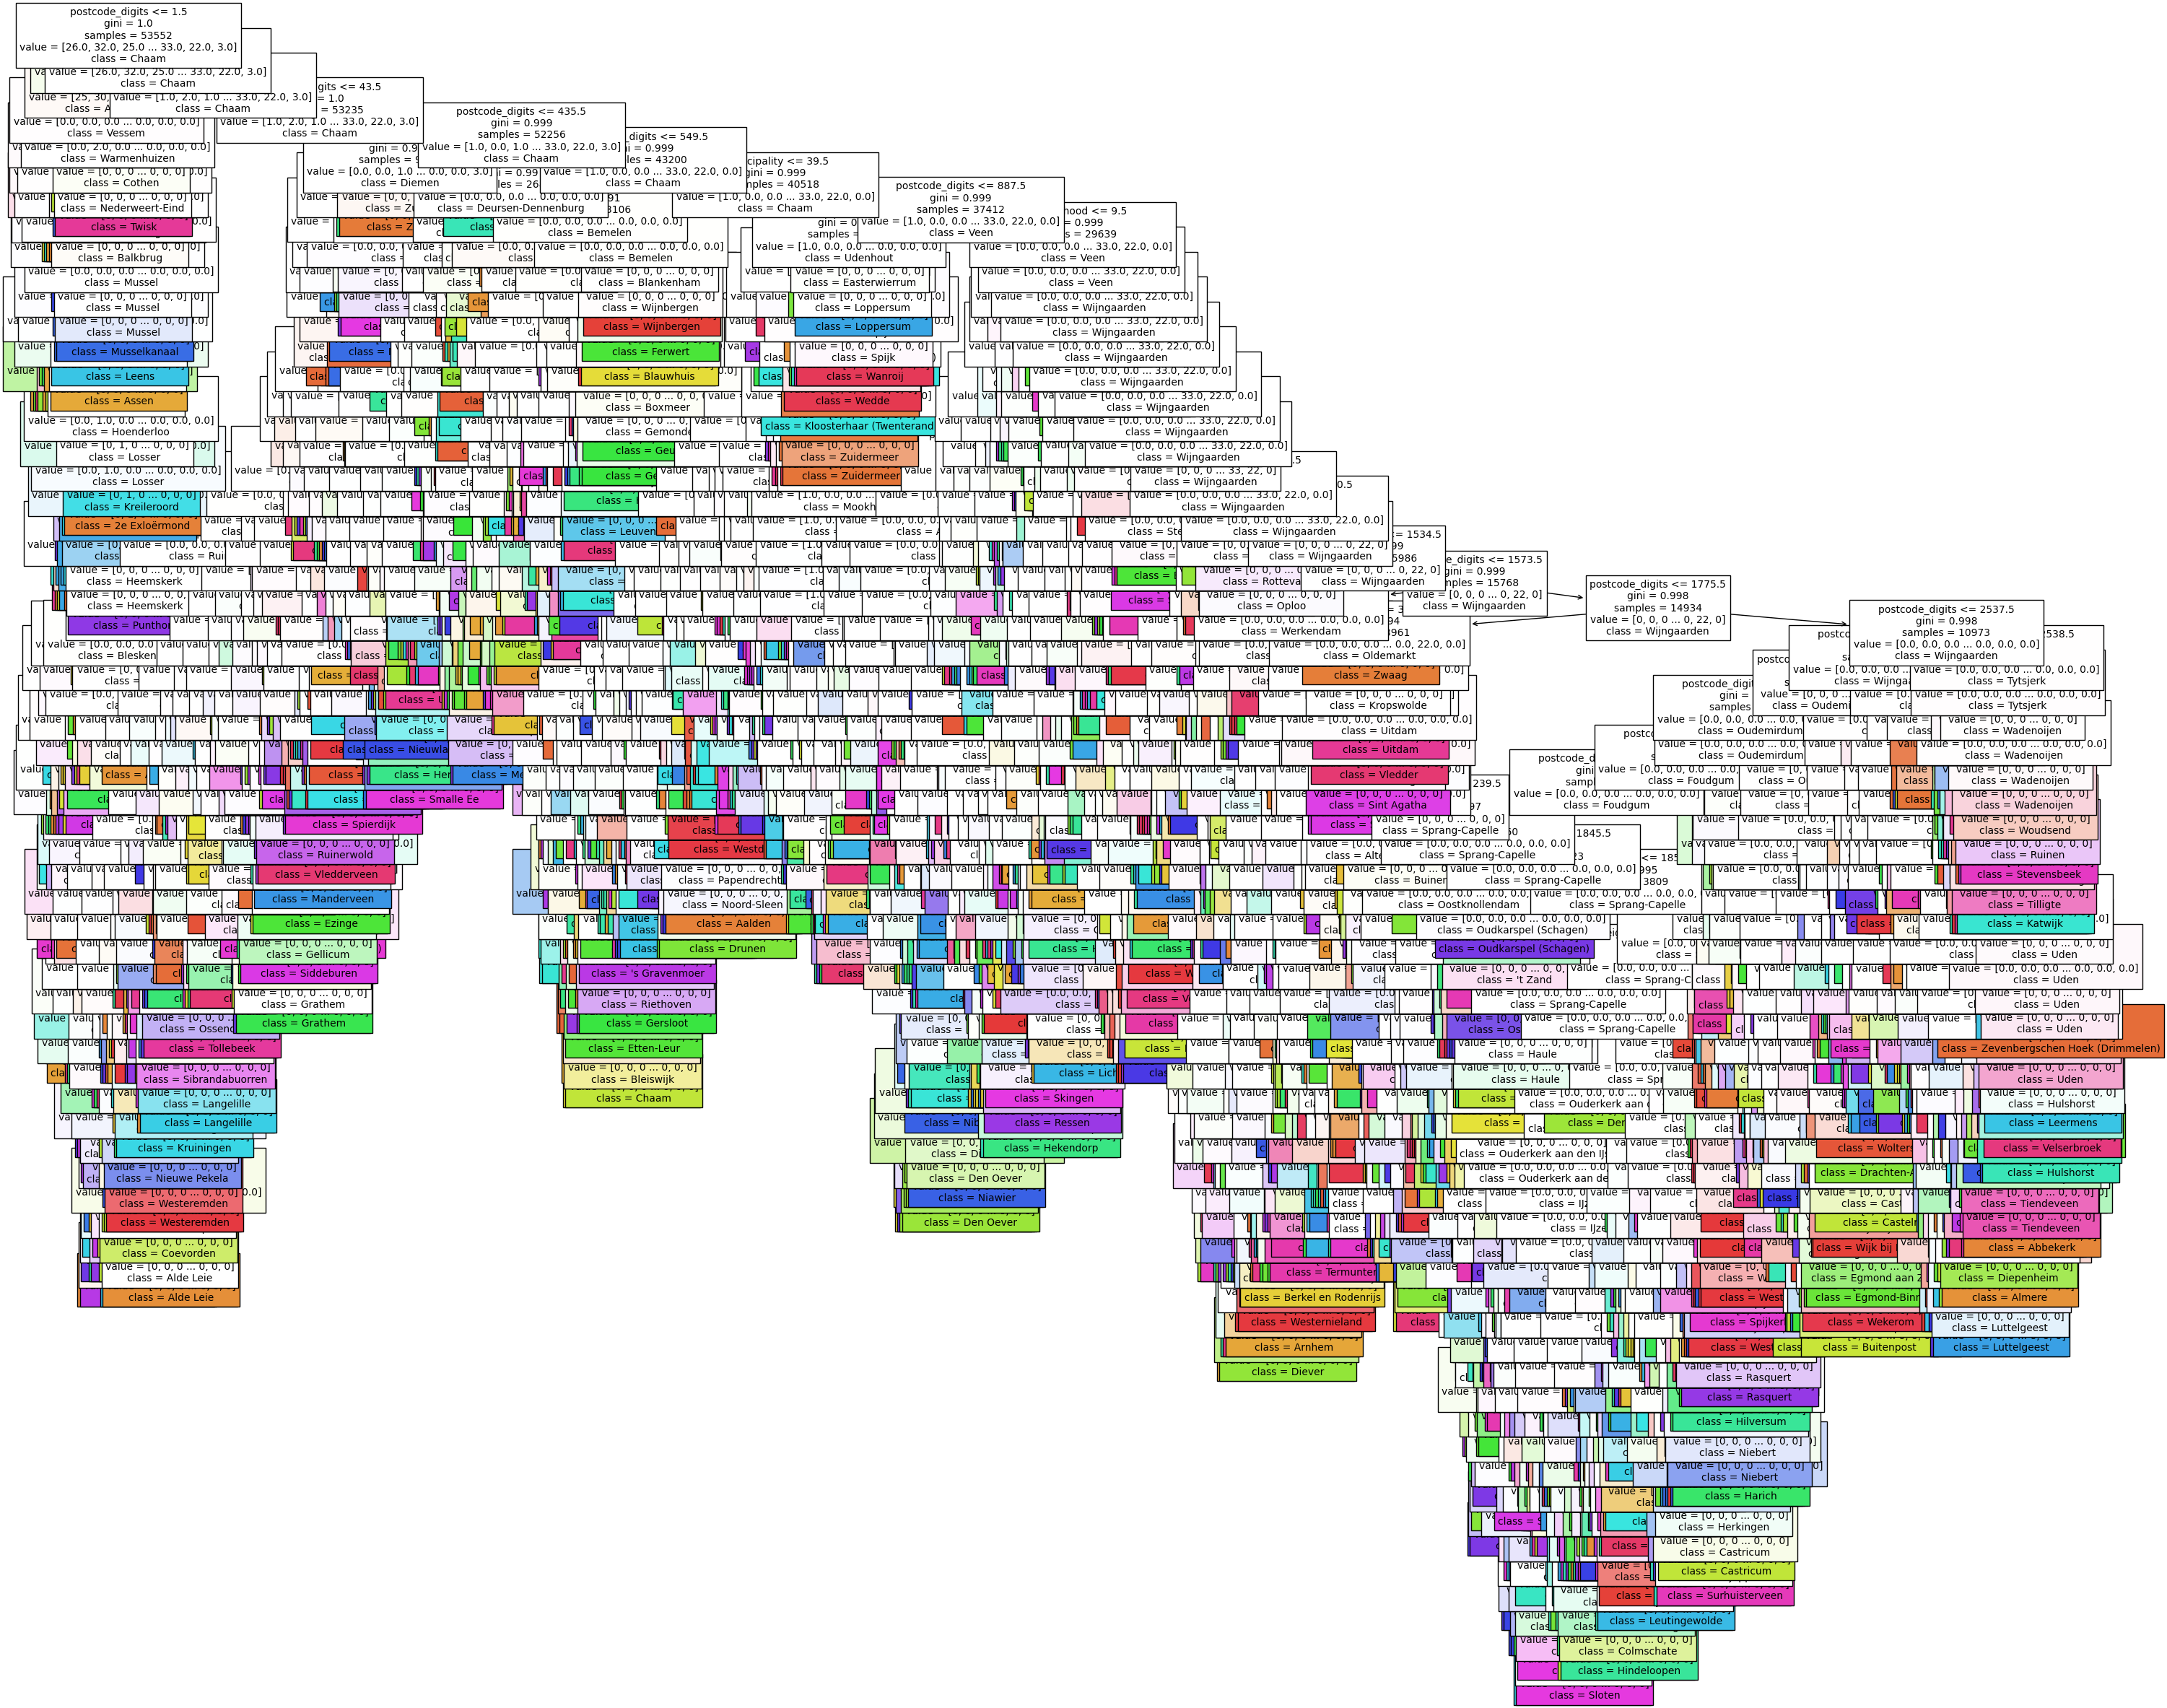

In [ ]:
# Visualize new decision tree
plt.figure(figsize=(35, 30))

# Get unique city names and convert them to a list for class_names
class_names = addresses_encoded['city'].unique().tolist()

plot_tree(best_dt_classifier, feature_names=X.columns, class_names=class_names, filled=True, fontsize=10)
plt.show()

As you can see, this is a very complex decision tree that is very difficult to read and interpret. So, I wanted to see if I could make it simpler. To do this, I first checked the depth of the decision tree to see how many Nodes were actually used

In [ ]:
best_tree_depth = best_dt_classifier.get_depth()
print(f"The depth of the decision tree is: {best_tree_depth}")

The depth of the decision tree is: 66


After calculating the depth, I iterated with a lower number for max depth and also increased the `min_samples_split` and `min_samples_leaf` to reduce the risk of overfitting

In [ ]:
new_dt_classifier = DecisionTreeClassifier(random_state=42,
                                          max_depth=45,
                                          min_samples_split=4,
                                          min_samples_leaf=3)

new_dt_classifier.fit(X_train, y_train)

new_y_pred_tree = new_dt_classifier.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, new_y_pred_tree))
print(classification_report(y_test, new_y_pred_tree))

Decision Tree Accuracy: 0.9118121214761884
                                  precision    recall  f1-score   support

                   's Gravenmoer       0.88      0.93      0.90        15
                    's-Graveland       1.00      1.00      1.00        10
                   's-Gravendeel       1.00      0.94      0.97        16
                 's-Gravenpolder       1.00      1.00      1.00         7
                  's-Gravenzande       1.00      1.00      1.00         9
               's-Heer Abtskerke       1.00      1.00      1.00        10
             's-Heer Arendskerke       1.00      1.00      1.00        12
        's-Heer Hendrikskinderen       1.00      0.86      0.92         7
                   's-Heerenberg       1.00      1.00      1.00        12
                  's-Heerenbroek       1.00      1.00      1.00         1
                   's-Heerenhoek       1.00      1.00      1.00        16
                          't Goy       1.00      1.00      1.00     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Although, this is not as accurate or precise as the best fit given by the gridsearchCV, it is still high enough. And because the idea is for a system where the user can input their own city or edit the recommended city, it is sufficient at _____% accuracy.

When I set `max_depth` to 35:

| **measure**    |**precision**   | **recall** | **f1-score**   |**support**|
|accuracy        |                |            |  0.71          | 22951     |
|macro avg       |         0.60   |     0.61   |     0.60       |    22951  |
|weighted avg    |      0.69      |     0.71   |     0.69       |   22951   |

When I set `max_depth` to 40:
|accuracy       |                 |            |   0.83     |  22951 |
|macro avg       |   0.72    |   0.73      0.72     22951
weighted avg       0.82      0.83      0.82     22951

When I set `max_depth` to 45:
accuracy                               0.91     22951
macro avg          0.83      0.83      0.82     22951
weighted avg       0.91      0.91      0.91     22951

Based on this, I would recommend a `max_depth` of 40. It is less complex than 45, but still high enough to be accurate and it still scores good enough on precision and recall

### A2.3 Neural Networks with Keras

In [ ]:
# Import libraries for Keras
%pip install tensorflow
%pip install keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached certifi-2024.12.14-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 MB 2.6 MB/s eta 0:00:0

In [ ]:
selected_addresses = addresses_clean.drop(columns=['area', 'province'])
selected_addresses = pd.get_dummies(selected_addresses, columns=['street', 'neighborhood', 'municipality', 'postcode_digits'], drop_first=True)
selected_addresses

,city,street_'s Gravenhoven,street_'s Gravenlust,street_'s Heer Boeijenstraat,street_'s-Gravelandseweg,street_'s-Gravenhof,street_'s-Gravenhofplein,street_'s-Gravenhofstraat,street_'s-Gravenpoldersestraat,street_'s-Gravensloot,...,postcode_digits_9989,postcode_digits_9991,postcode_digits_9992,postcode_digits_9993,postcode_digits_9994,postcode_digits_9995,postcode_digits_9996,postcode_digits_9997,postcode_digits_9998,postcode_digits_9999
0,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1e Exloërmond,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76498,Zwolle,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76499,Zwolle,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76500,Zwolle,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76501,Zwolle,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Define features (X) and target (y)
X = selected_addresses.drop(columns=['city'])
y = selected_addresses['city']

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y=label_encoder.fit_transform(y)

In [ ]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
num_cities = selected_addresses['city'].nunique()
print(f"Number of unique cities: {num_cities}")

Number of unique cities: 2473


After multiple tries and googling, I saw that I had to change the activation method from "sigmoid" to "softmax". and use the number of cities as the number of output neurons (which I calculted using `.nunique()`) above

In [ ]:
# Build a simple Neural Network
nn_model = Sequential([
    Dense(16, activation='relu', input_dim=X_train.shape[1]),
    Dense(8, activation='relu'),
    Dense(2473, activation='softmax')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.utils import to_categorical

num_classes = 2473
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Train the model
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/10
1339/1339 [==============================] - 7s 5ms/step - loss: 6.8185 - accuracy: 0.0126 - val_loss: 5.5480 - val_accuracy: 0.0493
Epoch 2/10
1339/1339 [==============================] - 5s 4ms/step - loss: 4.2283 - accuracy: 0.1951 - val_loss: 3.3343 - val_accuracy: 0.3567
Epoch 3/10
1339/1339 [==============================] - 6s 4ms/step - loss: 2.3186 - accuracy: 0.5605 - val_loss: 1.8629 - val_accuracy: 0.7040
Epoch 4/10
1339/1339 [==============================] - 6s 4ms/step - loss: 1.1675 - accuracy: 0.8189 - val_loss: 1.0672 - val_accuracy: 0.8650
Epoch 5/10
1339/1339 [==============================] - 6s 4ms/step - loss: 0.6046 - accuracy: 0.9227 - val_loss: 0.7074 - val_accuracy: 0.9163
Epoch 6/10
1339/1339 [==============================] - 6s 4ms/step - loss: 0.3469 - accuracy: 0.9587 - val_loss: 0.5333 - val_accuracy: 0.9436
Epoch 7/10
1339/1339 [==============================] - 6s 4ms/step - loss: 0.2226 - accuracy: 0.9717 - val_loss: 0.4332 - val_accuracy:

718/718 [==============================] - 2s 2ms/step - loss: 0.3601 - accuracy: 0.9663
Neural Network Accuracy: 0.9663195610046387


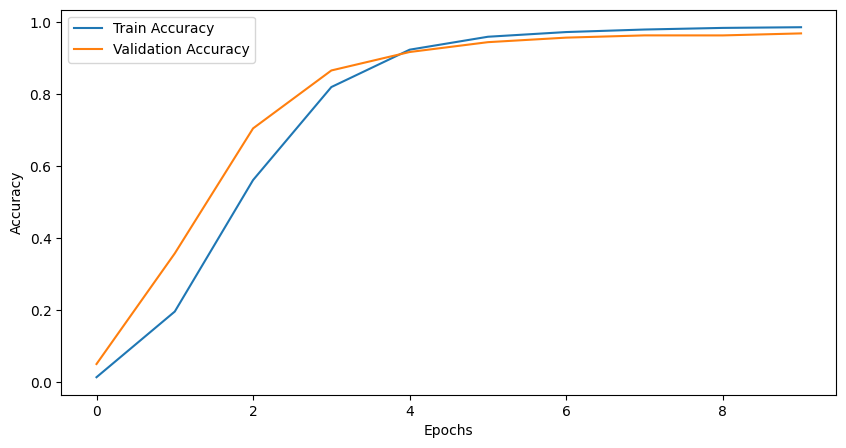

In [ ]:
# Evaluate the model
loss, accuracy = nn_model.evaluate(X_test, y_test)
print("Neural Network Accuracy:", accuracy)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### A2.3.1 Model Evaluation: Neural Network Model

The reduction in loss and increase in accuracy over each epoch shows that the model is learning effectively and getting better at predicting the correct city. The validation accuracy is also close to the training accuracy which shows that the model is probably not overfitting.

This shows that the neural network is effectively identifying the relationships in the data.

The next step would be to continue to tweak the parameters of the model and evaluate it on other address data that it hasn't seen yet

## A3. Conclusions and Relections

**Conclusions**

For the k-NN model, at 5 neighbours, the model has an accuracy of 99.3% and a weighted f1 score of 99% with the features: street, `neighborhood`, `municipality`, and `postcode_digits`.

The Decision Tree model, at `max_depth` of 40 is 83% accurate and has a weighted f1 score of 82%.

And the neural network had an accuracy of 96%

Based on my results, I would recommend the k-NN model as the best model for this dataset because it has the highest accuracy and weighted f1 score. Although it might require further iterations to ensure the model is not overfitted, it is simpler and easier to interpret than a Nueral Network.

**Reflections**

I intially struggled with what to do because the whole dataset consists of categorical data. It was clear for me what to explore within the data before pre-processing it for training the models.

I experimented a lot with some of the parameters for the different models (see above for k-NN and Decision Tree). I thought a lot about how to choose the right values for the parameters to have an efficient model that is not too complex (as with the Decision Tree) or too simple (as with the k-NN).

The most challenging part was the Neural Network as I had to change a lot of the parameters from what we did in the class because I had a lot of possible outcomes (over 2000).

